In [26]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
from src.models import CrossEntropyClassification
from src.data import train_val_test_split, get_descriptor_and_labels
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, RichProgressBar
import torch
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
numb_train_samples = 8_000

In [28]:
train_structs, val_structs, test_structs = train_val_test_split(mda=True,num_files=None)

In [4]:
len(train_structs), len(val_structs), len(test_structs)

(1285, 20, 1245)

In [5]:
train_x, train_y, label_mapping = get_descriptor_and_labels(train_structs,num_samples_per_type=numb_train_samples)
val_x, val_y, _ = get_descriptor_and_labels(val_structs, num_samples_per_type=2_500)
test_x, test_y, _ = get_descriptor_and_labels(test_structs, num_samples_per_type=2_500)

In [6]:
label_mapping

{'hda': 0, 'lda': 1, 'mda': 2}

In [7]:
from sklearn import preprocessing

# fit to training data
scaler = preprocessing.StandardScaler().fit(train_x)
scaled_train_x = torch.FloatTensor(scaler.transform(train_x))
scaled_val_x = torch.FloatTensor(scaler.transform(val_x))

train_dataset = TensorDataset(scaled_train_x,train_y)
val_dataset = TensorDataset(scaled_val_x,val_y)

train_loader = DataLoader(train_dataset, batch_size=250, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10000, shuffle=False)

In [8]:
import optuna
study_name = "optimise_NN"  # Unique identifier of the study.
storage_name = f"sqlite:///{study_name}.db"
study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True)

[I 2023-12-11 15:15:39,399] Using an existing study with name 'optimise_NN' instead of creating a new one.


In [9]:
optimised_NN_params = study.best_params

In [10]:
optimised_NN_params

{'n_layers': 3,
 'n_units_l0': 82,
 'weight_decay': 0.006363505017122275,
 'learning_rate': 0.0001363056995309084}

In [11]:
n_layers, neurons_per_layer, weight_decay, lr = optimised_NN_params.values()

In [12]:
n_layers, neurons_per_layer, weight_decay, lr

(3, 82, 0.006363505017122275, 0.0001363056995309084)

In [13]:
# define the neural network architecture
input_size = scaled_train_x.shape[1]
output_size = train_y.shape[1] # number of labels

hidden_layers = [neurons_per_layer] * n_layers

torch.manual_seed(42)
neural_net = CrossEntropyClassification(
    input_size,
    *hidden_layers,
    output_size,
    learning_rate=lr,
    weight_decay=weight_decay,
)

In [14]:
trainer = Trainer(
        accelerator="auto",
        max_epochs=200,
        callbacks=[
            RichProgressBar(),
            EarlyStopping(monitor="validation_loss", patience=10),
        ],
    )
trainer.fit(neural_net, train_loader, val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ activation │ ReLU       │      0 │
│ 1 │ layers     │ ModuleList │ 16.4 K │
└───┴────────────┴────────────┴────────┘

Trainable params: 16.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 16.4 K                                                                                               
Total estimated model params size (MB): 0

Output()

/Users/zoefaurebeaulieu/miniconda3/envs/steinhardt/lib/python3.10/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may 
be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus 
on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

/Users/zoefaurebeaulieu/miniconda3/envs/steinhardt/lib/python3.10/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which 
may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of 
cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

In [15]:
# generate test set predictions
from src.data import predict_test_set_classes
from sklearn.metrics import balanced_accuracy_score

pred_classes, test_classes, confidences = predict_test_set_classes(test_structs,model=neural_net, scaler=scaler)

av_accuracy = balanced_accuracy_score(test_classes, pred_classes)
print(f"Average balanced accuracy: {av_accuracy:.3f}")

Average balanced accuracy: 0.856


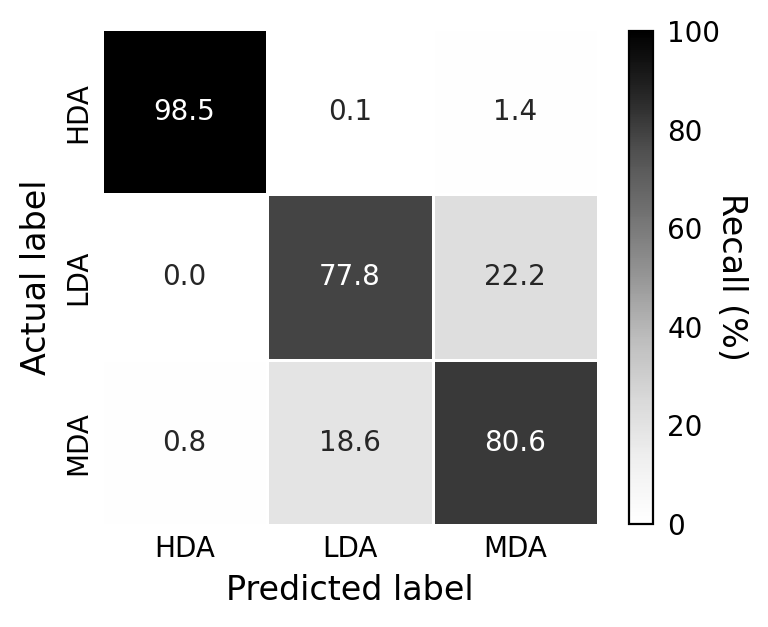

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.style.use('default')

fig, ax = plt.subplots(figsize=(4,4))

cm = confusion_matrix(test_classes, pred_classes, normalize='true')
sns.heatmap(cm*100, annot=True, ax=ax, cmap='Greys', fmt='.1f',linewidths=0.5,square=True,cbar=False)

plot_labels = ['HDA','LDA', 'MDA']
ax.set_xticks([0.5, 1.5, 2.5],plot_labels)
ax.set_yticks([0.5, 1.5, 2.5],plot_labels)

# remove spines
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
ax.set_ylabel('Actual label',fontsize=12);
ax.set_xlabel('Predicted label',fontsize=12);
ax.tick_params(length=0)
    
# add a colorbar
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=0, vmax=100)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Greys)
cmap.set_array([])
cbar = fig.colorbar(cmap, ax=ax,shrink=0.8)
cbar.set_label('Recall (%)', rotation=270, labelpad=10,fontsize=12)
# change the cbar tick length
cbar.ax.tick_params(length=0,pad=5)

# plt.savefig('../figures/NN_cm.svg',dpi=300,bbox_inches='tight')

In [17]:
from src.data import get_kde
x_values = np.linspace(40,110,400)
kdes = []
for i in range(0,len(plot_labels)):
    kde = get_kde(confidences[test_classes==i]*100,x_values,normalise=True)
    kdes.append(kde)

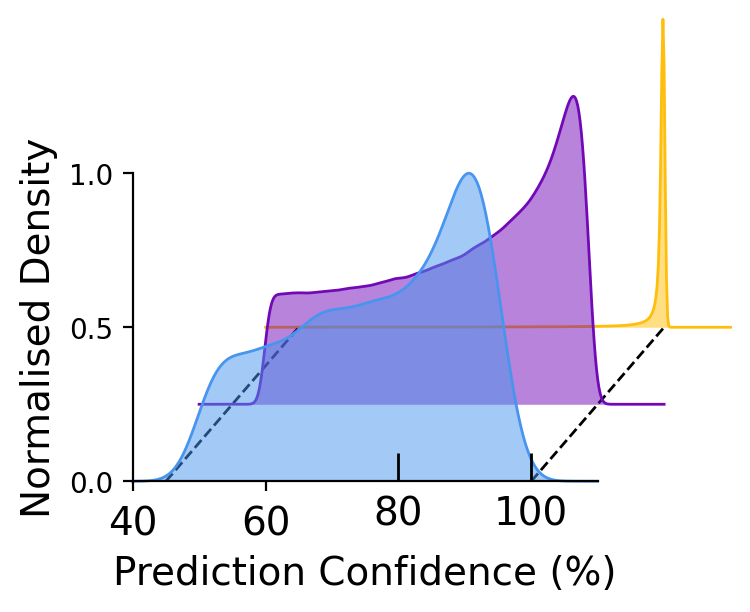

In [18]:
fig, ax = plt.subplots(figsize=(3,2))
plt.style.use('plot.mplstyle')

# labels = ['HDA','LDA','MDA']
# colors = ['#ffbe0b','#7209b7','#4895ef']
liquid_color = 'ff006e'

labels = ['HDA','LDA','MDA']
colors = ['#ffbe0b','#7209b7','#4895ef']

for i in range(0,len(labels)):
    dx, dy = -i*10, -i*0.25 + 0.5
    ax.plot(x_values + dx, kdes[i] + dy, label=labels[i], color=colors[i], zorder=i,linewidth=1,clip_on=False)
    ax.fill_between(x_values + dx, kdes[i] + dy, dy, color=colors[i], zorder=i, label=labels[i],alpha=0.5,linewidth=0,clip_on=False)
    
ax.plot([80,100],[0,0.5],color='black',linestyle='dashed',linewidth=1,zorder=0,clip_on=False)
ax.plot([25,45],[0,0.5],color='black',linestyle='dashed',linewidth=1,zorder=0,clip_on=False)

# remove top and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xticks([20,40,60,80])
ax.set_xticklabels([40,60,80,100],fontsize=14)

#reduce space between x-axis and labels
ax.tick_params(axis='x', which='major', pad=5)

# have x ticks in front of plot
ax.set_axisbelow(False)

ax.set_ylim(0,1)
ax.set_xlim(20,90)

# plt.legend(fontsize=12,loc='upper left')
ax.set_xlabel('Prediction Confidence (%)',fontsize=14);
ax.set_ylabel('Normalised Density',fontsize=14);

# plt.savefig('../figures/NN_confidence.svg',dpi=300,bbox_inches='tight')

In [19]:
index_mapping = {}
for key, value in label_mapping.items():
    index_mapping[value] = key

In [73]:
from src.data import predict_lda_traj_classes

temp = 140
run = 1

proportions_per_pressure = predict_lda_traj_classes(trajectory_type='compression',temperature=temp,run=run,model=neural_net,scaler=scaler,write_to_file=False)

In [74]:
proportions_per_struct_type = {index_mapping[class_num]: [proportions_per_pressure[p][class_num] for p in proportions_per_pressure.keys()] for class_num in range(len(label_mapping))}

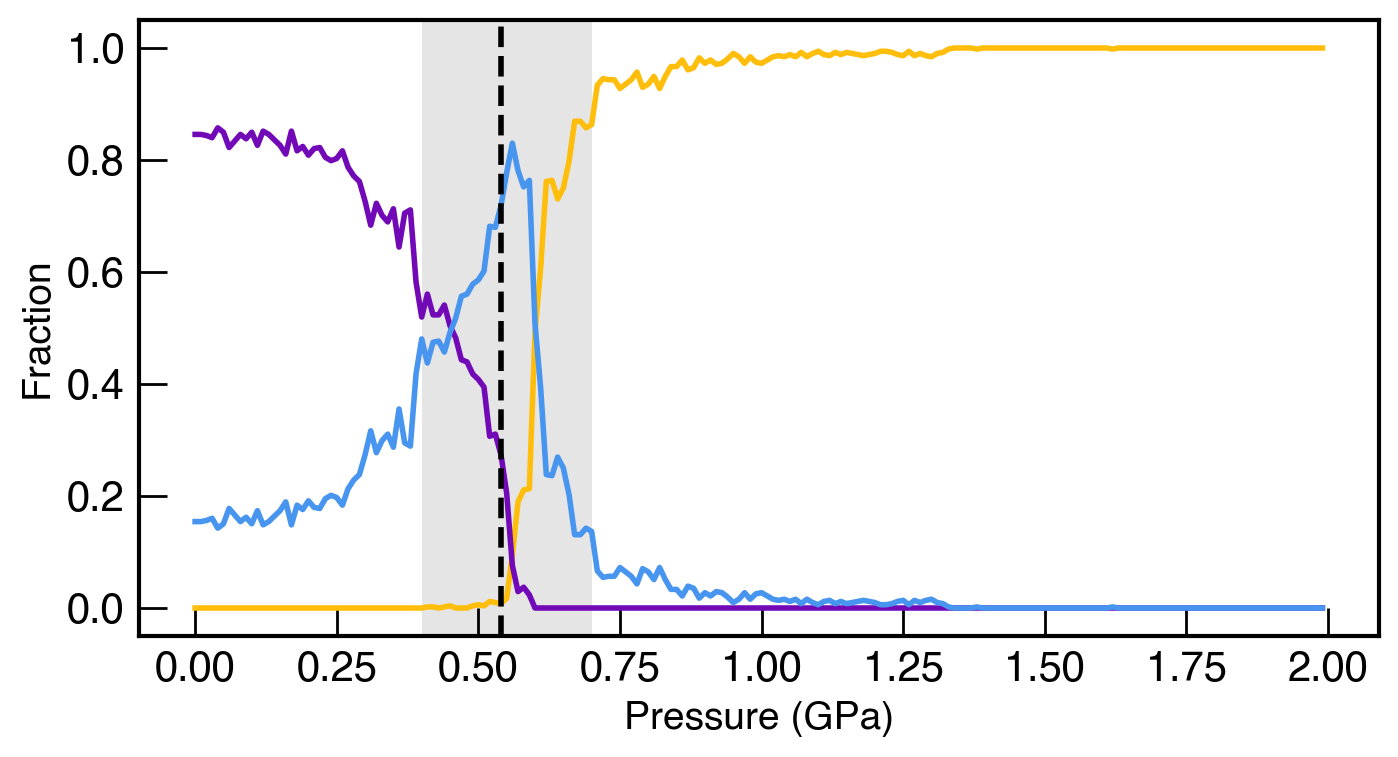

In [75]:
# plot the proportion of each class at each temperature
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('plot.mplstyle')
fig, ax = plt.subplots(figsize=(8,4))

# obtained from the MDA analysis
# found in the steinhardt_analysis.ipynb notebook
mda_best_match ={
    100: 0.72,
    120: 0.68,
    140: 0.54,
}

phase_change_pressures = {
    100: (0.6, 0.85),
    120: (0.62, 0.84),
    140: (0.4, 0.7),
}

labels = ['HDA','LDA','MDA']
colors = ['#ffbe0b','#7209b7','#4895ef']

pressures = np.arange(0,2,0.01)

for i,(class_name, data) in enumerate(proportions_per_struct_type.items()):
    ax.plot(pressures,data,label=labels[i],color=colors[i],linewidth=2)
    
# draw a dashed vertical line at the MDA best match pressure
ax.axvline(mda_best_match[temp],color='k',linestyle='--',linewidth=2)

# shaded region for phase transition
ax.axvspan(phase_change_pressures[temp][0], phase_change_pressures[temp][1], alpha=0.1, color='k',linewidth=0)

ax.set_xlabel('Pressure (GPa)',fontsize=14)
ax.set_ylabel('Fraction',fontsize=14)

ax.tick_params(axis='both', which='major', pad=5)


plt.savefig(f'../figures/trajectories_proportions_temp{temp}.svg',dpi=300,bbox_inches='tight')
# ax.legend(fontsize=12,loc='upper left',bbox_to_anchor=(1,0.65))
